In [0]:

!pip install git+https://github.com/aleju/imgaug

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-zx82bg2g
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-zx82bg2g
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xwxn_2a/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import PIL
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from imgaug import augmenters as iaa
import imgaug as ia
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from torchsummary import summary

plt.ion()

In [0]:
!unzip dataset.zip


In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential(
    [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.2),
        sometimes(iaa.Crop(percent=(0, 0.1))),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),
        iaa.SomeOf((0, 5),
            [
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),
                iaa.Invert(0.05, per_channel=True),
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.5, 1.5), per_channel=0.5),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [0]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(224),
#        transforms.CenterCrop(224),
#        transforms.RandomResizedCrop(224),
        ImgAugTransform(),
        lambda x: PIL.Image.fromarray(x),
#        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness = (1,1.5), contrast = (1,2), saturation = (0,2), hue = (0,0.5)),
#        transforms.RandomVerticalFlip(),
#        transforms.RandomApply([
#            transforms.RandomAffine(90),
#            transforms.RandomGrayscale()
#        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Val', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=86, shuffle=True, num_workers=4) for x in ['Train', 'Val','Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val','Test']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [1]:
print(class_names)
print(len(class_names))
print(dataset_sizes)
print(image_datasets['Val'])

NameError: ignored

In [37]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def show_confusion_matrix(model):
  nb_classes = len(class_names)
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloaders['Test']):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  df_cm = pd.DataFrame(confusion_matrix.numpy(), range(nb_classes),range(nb_classes))
  sn.set(font_scale=1.4)
  sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})
  sn.plotting_context
  plt.show()

In [0]:
def show_loss(val,train):
#   ax = plt.gca()
#   ax.set_xlabel('epoch')
#   ax.set_ylabel('loss')
#   ax.grid(True)
  
#   ax.plot(val, label=u'Гиперболический тангенс')
#   plt.show()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(val,'b',label=u'val')
    ax1.plot(train,'r',label=u'train')
    ax1.set_xlabel('epoch',size=16,color='black')
    ax1.set_ylabel('loss',size=16, color='black')
    ax1.grid(True)
    ax1.legend(loc='best',frameon=False)

    plt.tight_layout() # автоматическое выравнивание элементов на холсте plt

    plt.show()
  

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss_buffer_array = []
    val_loss_buffer_array = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'Train':
                train_loss_buffer_array.append([epoch_loss])
            else:
                val_loss_buffer_array.append([epoch_loss])
            #torch.save(model_ft.state_dict(), 'model_weight')
            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        show_confusion_matrix(model)
        show_loss(val_loss_buffer_array,train_loss_buffer_array)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_loss_buffer_array, val_loss_buffer_array]

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: ' + str(class_names[preds[j]]) + ' original :' + str(labels[j].item()))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
def test_model_on_testdata(model):
  running_loss = 0 
  running_corrects = 0
  for i, (inputs, labels) in enumerate(dataloaders['Test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
  #print(running_loss)
  print(str(running_corrects.item()) + ' / ' + str(dataset_sizes['Test']))
  print(str(running_corrects.item()/dataset_sizes['Test']) + " %")
  

In [0]:
model_ft3 = models.vgg16(pretrained=True)
for param in model_ft2.parameters():
    param.requires_grad = False

mod = list(model_ft3.classifier.children())
mod.pop()
mod.append(nn.Linear(4096,10))
#mod.append(nn.ReLU())
#mod.append(nn.Linear(1000,10))


model_ft3.classifier = nn.Sequential(*mod)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft3 = model_ft3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [31]:
summary(model_ft2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Epoch 0/24
----------
Train Loss: 2.2984 Acc: 0.1496
Val Loss: 2.0133 Acc: 0.3714



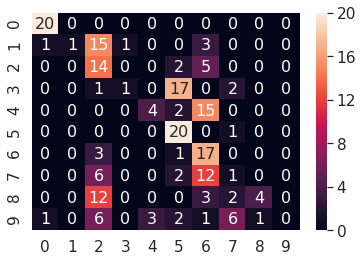

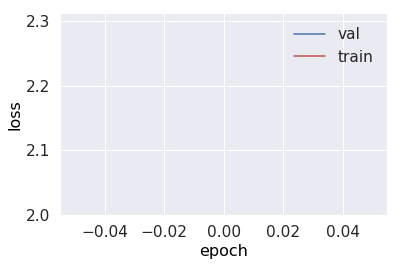

Epoch 1/24
----------
Train Loss: 1.9184 Acc: 0.3181
Val Loss: 1.1798 Acc: 0.6143



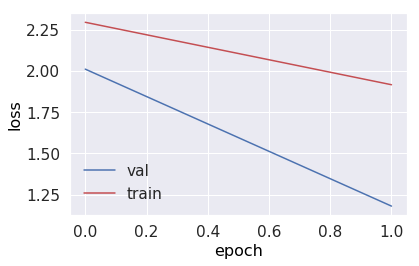

Epoch 2/24
----------
Train Loss: 1.4358 Acc: 0.4811
Val Loss: 0.7123 Acc: 0.7952



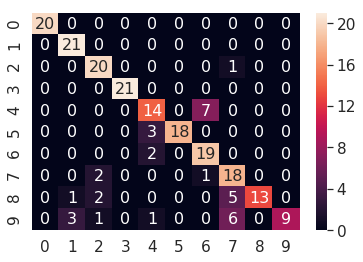

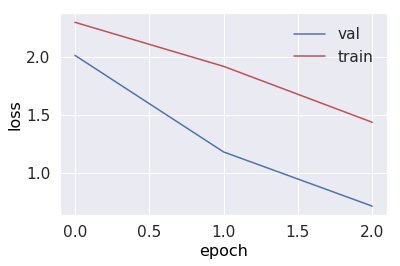

Epoch 3/24
----------
Train Loss: 1.0752 Acc: 0.6016
Val Loss: 0.4845 Acc: 0.8810



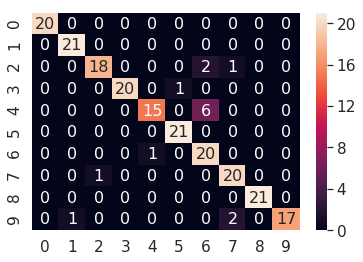

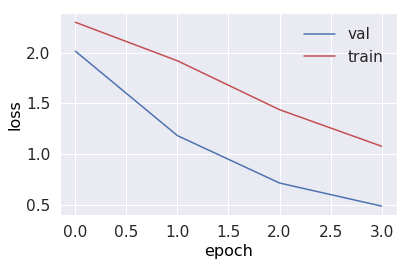

Epoch 4/24
----------
Train Loss: 0.8982 Acc: 0.6794
Val Loss: 0.3809 Acc: 0.8714



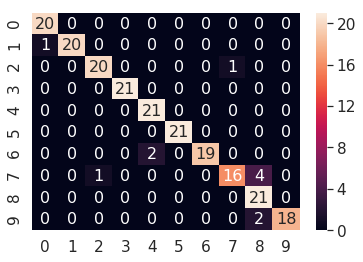

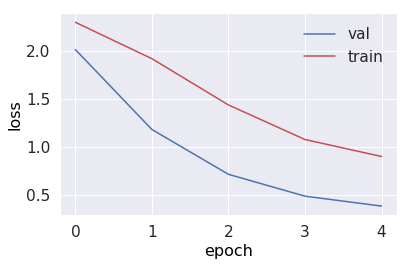

Epoch 5/24
----------
Train Loss: 0.7651 Acc: 0.7433
Val Loss: 0.3521 Acc: 0.8762



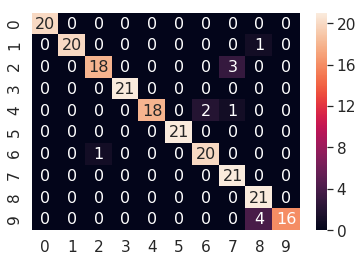

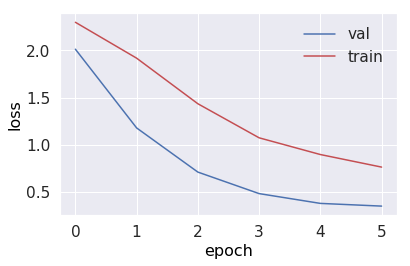

Epoch 6/24
----------
Train Loss: 0.6537 Acc: 0.7670
Val Loss: 0.2019 Acc: 0.9524



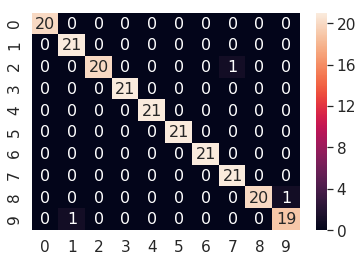

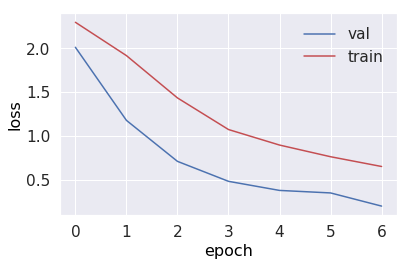

Epoch 7/24
----------
Train Loss: 0.5943 Acc: 0.7828
Val Loss: 0.1912 Acc: 0.9476



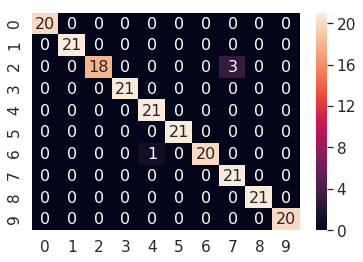

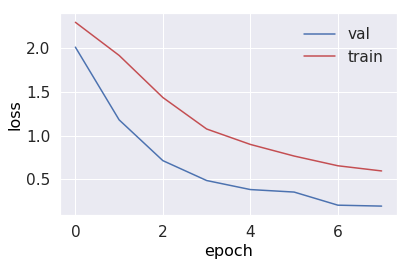

Epoch 8/24
----------
Train Loss: 0.6204 Acc: 0.7841
Val Loss: 0.1669 Acc: 0.9619



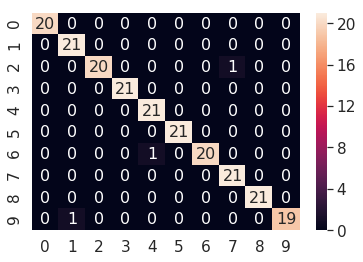

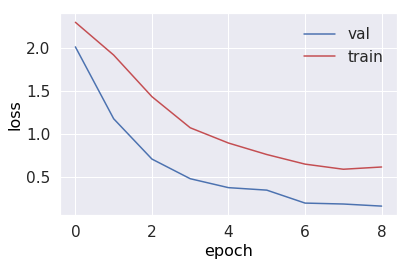

Epoch 9/24
----------
Train Loss: 0.5750 Acc: 0.8023
Val Loss: 0.1813 Acc: 0.9476



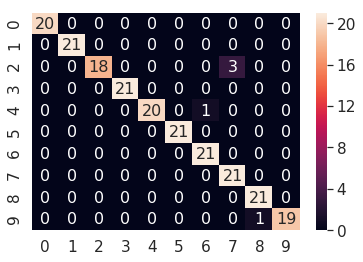

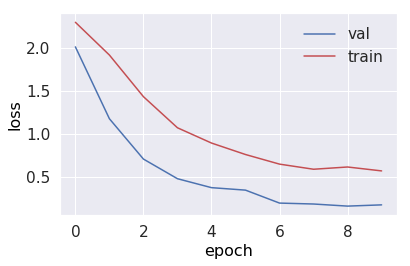

Epoch 10/24
----------
Train Loss: 0.5504 Acc: 0.7944
Val Loss: 0.1529 Acc: 0.9619



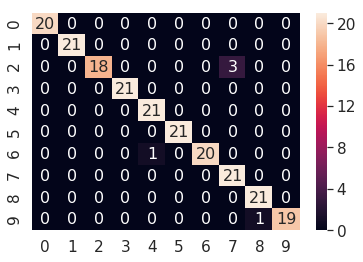

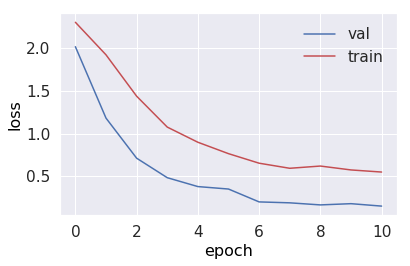

Epoch 11/24
----------
Train Loss: 0.5621 Acc: 0.7889
Val Loss: 0.1375 Acc: 0.9714



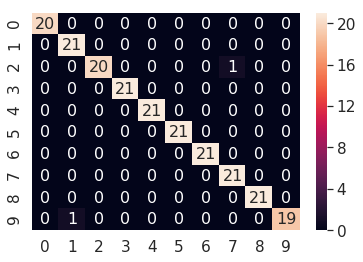

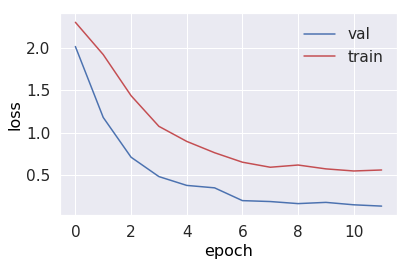

Epoch 12/24
----------
Train Loss: 0.5503 Acc: 0.8163
Val Loss: 0.1559 Acc: 0.9619



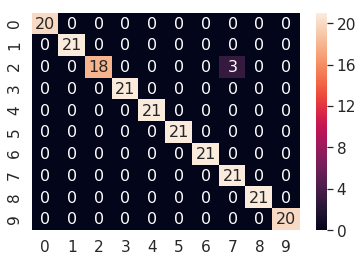

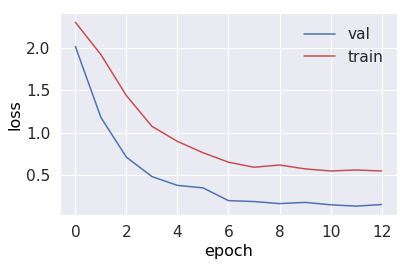

Epoch 13/24
----------
Train Loss: 0.5438 Acc: 0.8054
Val Loss: 0.1542 Acc: 0.9619



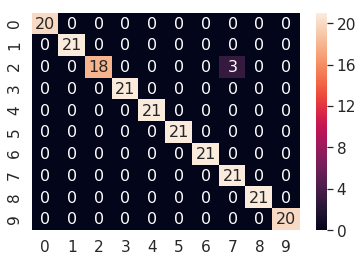

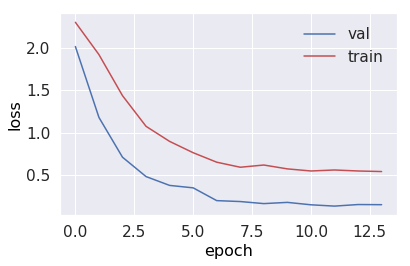

Epoch 14/24
----------
Train Loss: 0.5769 Acc: 0.7956
Val Loss: 0.1457 Acc: 0.9714



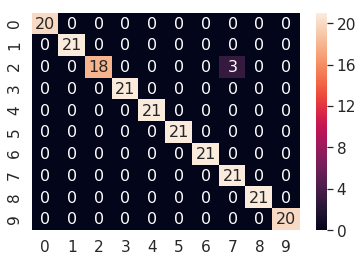

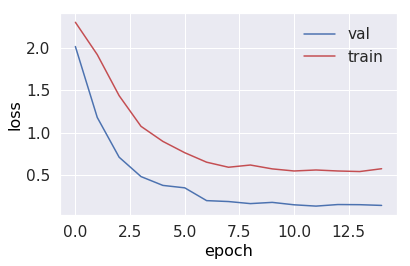

Epoch 15/24
----------
Train Loss: 0.5152 Acc: 0.8084
Val Loss: 0.1407 Acc: 0.9762



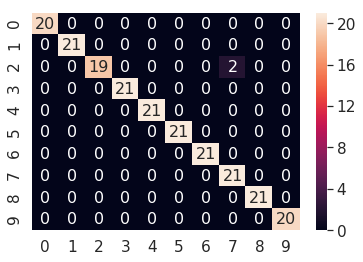

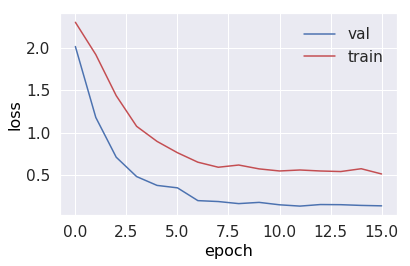

Epoch 16/24
----------
Train Loss: 0.5109 Acc: 0.8242
Val Loss: 0.1392 Acc: 0.9714



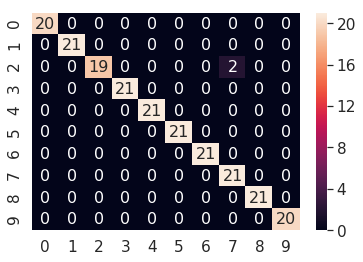

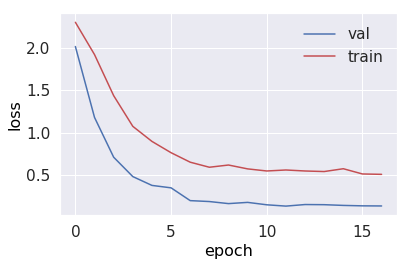

Epoch 17/24
----------
Train Loss: 0.5244 Acc: 0.8200
Val Loss: 0.1392 Acc: 0.9714



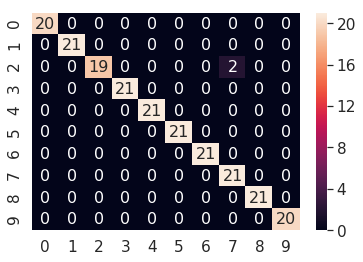

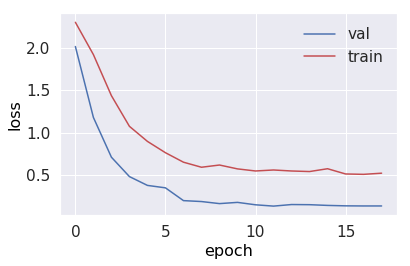

Epoch 18/24
----------
Train Loss: 0.5106 Acc: 0.8218
Val Loss: 0.1402 Acc: 0.9667



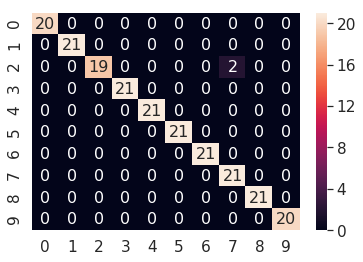

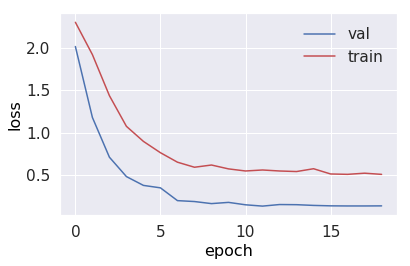

Epoch 19/24
----------
Train Loss: 0.5257 Acc: 0.7968
Val Loss: 0.1387 Acc: 0.9667



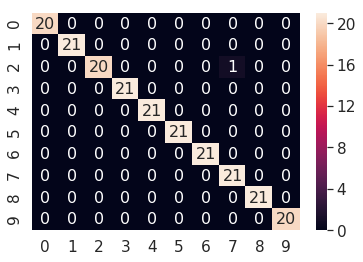

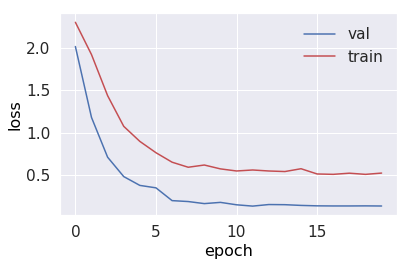

Epoch 20/24
----------
Train Loss: 0.5275 Acc: 0.8157
Val Loss: 0.1385 Acc: 0.9667



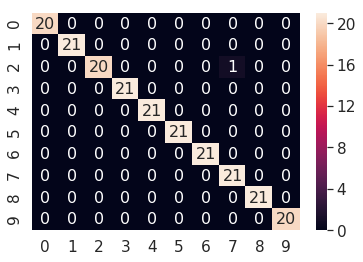

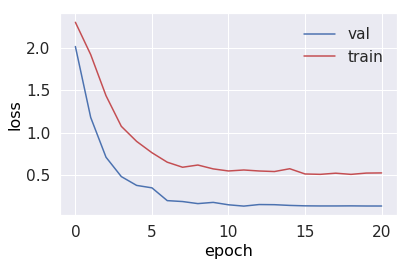

Epoch 21/24
----------
Train Loss: 0.5384 Acc: 0.8023
Val Loss: 0.1383 Acc: 0.9667



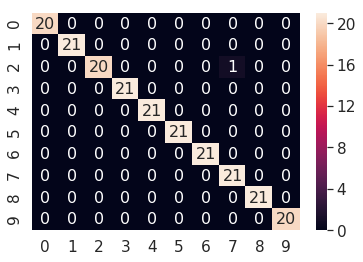

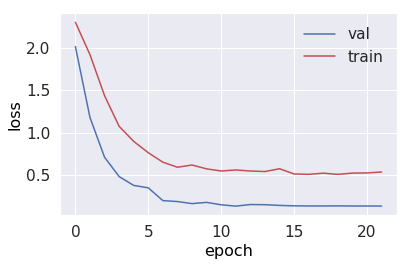

Epoch 22/24
----------
Train Loss: 0.5154 Acc: 0.8047
Val Loss: 0.1381 Acc: 0.9667



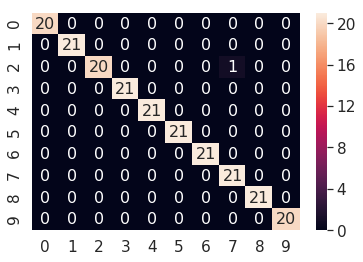

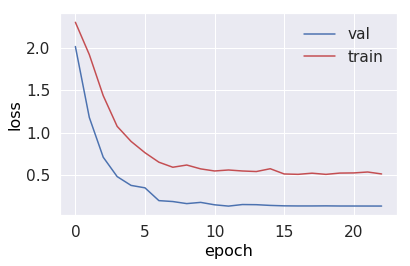

Epoch 23/24
----------
Train Loss: 0.5416 Acc: 0.8072
Val Loss: 0.1378 Acc: 0.9667



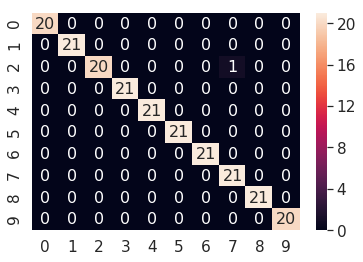

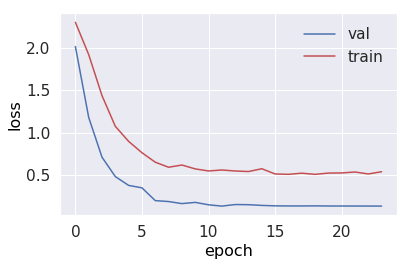

Epoch 24/24
----------
Train Loss: 0.5269 Acc: 0.8145
Val Loss: 0.1374 Acc: 0.9667



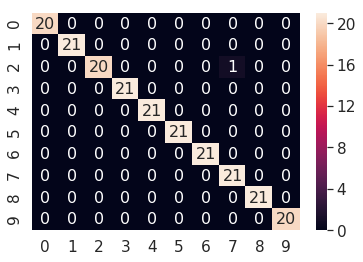

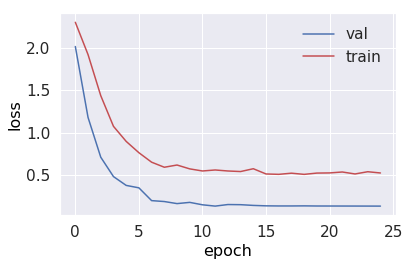

Training complete in 17m 6s
Best val Acc: 0.976190


In [39]:
model_ft3, loss_buffers = train_model(model_ft3, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

In [41]:
visualize_model(model_ft3)

RuntimeError: ignored

<Figure size 432x288 with 0 Axes>

In [40]:
test_model_on_testdata(model_ft3)

RuntimeError: ignored

In [0]:
torch.save(model_ft3.state_dict(), 'model_weight')